# Code validation with mock clusters

This notebook demonstrates how to make mock data of a cluster with or without linear velocity gradient and how to do the fitting with the mock data.

Notes on dependences
- [gapipes](https://github.com/smoh/gapipes): for custom pandas accessor `g` to get covariance matrices, astropy coordinate objects..
- [arviz](https://github.com/arviz-devs/arviz): for visualization

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import numpy as np
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coords
import arviz as az

# project dependencies
import gapipes as gp
import kinesis as kn

In [3]:
np.random.seed(18324)

## basic cluster model

### Basic cluster model with no RVs - astrometric radial velocity

In [4]:
N = 150  # number of sources
b0 = np.array([17.7, 41.2, 13.3])    # pc
v0 = np.array([-6.32, 45.24, 5.30])  # [vx, vy, vz] in km/s
sigv = 1.  # dispersion, km/s

cl = kn.Cluster(v0, sigv, b0=b0)\
       .sample_sphere(N=N, Rmax=5)\
       .observe(cov=np.eye(3)*0.01)

In [5]:
fitter = kn.Fitter(include_T=False)

INFO:kinesis.models:Reading model from disk


In [6]:
df = cl.members.observed.copy()
fit = fitter.fit(df, sample=False)
print(f"v0, sigv = {fit['v0']}, {fit['sigv']:.4f}")
print(f"diff from truth: {fit['v0']-v0}, {fit['sigv']-sigv:.4f}")

v0, sigv = [-6.05218859 45.77023958  5.55129011], 0.9072
diff from truth: [0.26781141 0.53023958 0.25129011], -0.0928


In [7]:
stanfit = fitter.fit(df)

In [8]:
# workaround for a bug in arviz instantiating InferenceData
d = stanfit.extract(permuted=False, pars=['v0', 'sigv'])
d = {k:np.swapaxes(v, 0, 1) for k,v in d.items()}
azfit = az.from_dict(d)

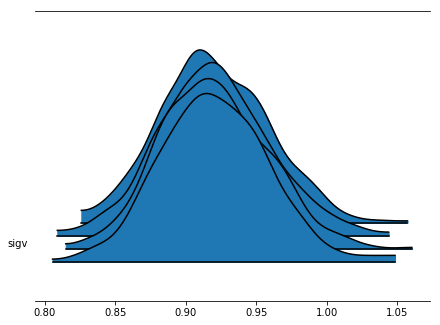

In [9]:
az.plot_forest(azfit, kind='ridgeplot', var_names=['sigv']);

In [10]:
stanfit.to_dataframe()['divergent__'].sum()

0

In [11]:
az.summary(azfit)

,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.060,0.426,0.010,0.007,-6.851,-5.268,1996.0,1996.0,1995.0,2378.0,1.0
v0[1],45.758,0.983,0.022,0.016,44.002,47.670,1980.0,1979.0,1976.0,2439.0,1.0
v0[2],5.548,0.325,0.007,0.005,4.917,6.137,1974.0,1971.0,1972.0,2484.0,1.0
sigv,0.920,0.038,0.000,0.000,0.850,0.993,9141.0,9031.0,9185.0,2277.0,1.0


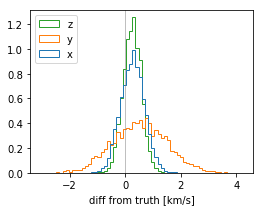

In [12]:
v0_diff = stanfit['v0'] - cl.v0[None,:]

plt.figure(figsize=(4,3))
plt.hist(v0_diff, bins=64, histtype='step', density=True, label=['x','y','z']);
plt.xlabel("diff from truth [km/s]");
plt.legend(loc='upper left');
plt.axvline(0, c='gray', lw=.5);

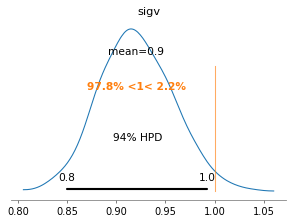

In [13]:
az.plot_posterior(azfit, var_names=['sigv'], ref_val=cl.sigmav, figsize=(4,3));

In [14]:
# plt.figure(figsize=(4,3))
# g = np.einsum('ni,nij,nj->n', a-r['a_model'], np.linalg.inv(C), a-r['a_model'])

# plt.hist(g, 32, density=True);
# plt.hist(g, np.logspace(0, 4, 32), density=True);
# plt.xscale('log');
# plt.yscale('log')

### Basic cluster model with partial RVs

In [15]:
N = 150
b0 = np.array([17.7, 41.2, 13.3])    # pc
v0 = np.array([-6.32, 45.24, 5.30])
sigv = 1.

cl = kn.Cluster(v0, sigv, b0=b0)\
       .sample_sphere(N=N, Rmax=5)\
       .observe(cov=np.eye(3)*0.01)

# Give random half of the stars RV with 0.5 km/s uncertainty
Nrv = int(N*0.5)
rv_error = 0.5
irand = np.random.choice(np.arange(N), size=Nrv, replace=False)

df = cl.members.observed.copy()
df['radial_velocity'] = np.random.normal(cl.members.truth['radial_velocity'].values, rv_error)
df['radial_velocity_error'] = rv_error

In [16]:
df = cl.members.observed.copy()
fit = fitter.fit(df, sample=False)
print(f"v0, sigv = {fit['v0']}, {fit['sigv']:.4f}")
print(f"diff from truth: {fit['v0']-v0}, {fit['sigv']-sigv:.4f}")

v0, sigv = [-5.92897309 46.06913061  5.49316135], 0.9835
diff from truth: [0.39102691 0.82913061 0.19316135], -0.0165


In [17]:
stanfit_partialrv = fitter.fit(df)

In [18]:
# workaround for a bug in arviz instantiating InferenceData
d = stanfit_partialrv.extract(permuted=False, pars=['v0', 'sigv'])
d = {k:np.swapaxes(v, 0, 1) for k,v in d.items()}
azfit_partialrv = az.from_dict(d)

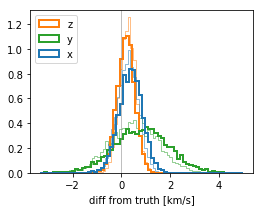

In [19]:
v0_diff0 = stanfit['v0'] - cl.v0[None,:]
v0_diff = stanfit_partialrv['v0'] - cl.v0[None,:]

plt.figure(figsize=(4,3))
color = ['tab:blue', 'tab:green', 'tab:orange']
plt.hist(v0_diff0, bins=64, histtype='step', density=True, color=color, lw=.5);
plt.hist(v0_diff, bins=64, histtype='step', density=True, color=color, label=['x','y','z'], lw=2);
plt.xlabel("diff from truth [km/s]");
plt.legend(loc='upper left');
plt.axvline(0, c='gray', lw=.5);

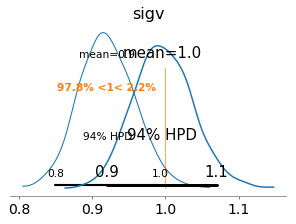

In [20]:
axs = az.plot_posterior(azfit, var_names=['sigv'], ref_val=cl.sigmav, figsize=(4,3))
az.plot_posterior(azfit_partialrv, var_names=['sigv'], ax=axs);

## Cluster with rotation

In [21]:
N = 150
b0 = np.array([17.7, 41.2, 13.3])    # pc
v0 = np.array([-6.32, 45.24, 5.30])
sigv = 1.
omegas = [40., 20., 50.]

cl = kn.Cluster(v0, sigv, b0=b0, omegas=omegas)\
       .sample_sphere(N=N, Rmax=15)\
       .observe(cov=np.eye(3)*0.001)
cl0 = kn.Cluster(v0, sigv, b0=b0).sample_at(cl.members.truth.g.icrs)

# Give random half of the stars RV with 0.5 km/s uncertainty
Nrv = int(N*0.5)
rv_error = 0.5
irand = np.random.choice(np.arange(N), size=Nrv, replace=False)

df = cl.members.observed.copy()
df['radial_velocity'] = np.random.normal(cl.members.truth['radial_velocity'].values, rv_error)
df['radial_velocity_error'] = rv_error

In [22]:
m = kn.Fitter(include_T=True)
fit = m.fit(df, sample=False, b0=b0)

INFO:kinesis.models:Reading model from disk


In [23]:
print(f"v0, sigv = {fit['v0']}, {fit['sigv']:.4f}")
print(f"diff from truth: {fit['v0']-v0}, {fit['sigv']-sigv:.4f}")
print(f"{fit['T_param']}")
print(f"{cl.T}")

v0, sigv = [-6.382561   45.25883593  5.52632739], 0.9632
diff from truth: [-0.062561    0.01883593  0.22632739], -0.0368
[[ -5.47942742 -48.81690422  14.15808424]
 [ 27.02856238   6.34378433 -29.12948134]
 [ -4.03730063  37.49138498  -3.81971577]]
[[  0. -50.  20.]
 [ 50.   0. -40.]
 [-20.  40.   0.]]


In [ ]:
# omegax = 0.5*(r['T_param'][2, 1] - r['T_param'][1, 2])
# omegay = 0.5*(r['T_param'][0, 2] - r['T_param'][2, 0])
# omegaz = 0.5*(r['T_param'][1, 0] - r['T_param'][0, 1])

# w1 = 0.5*(r['T_param'][2, 1] + r['T_param'][1, 2])
# w2 = 0.5*(r['T_param'][0, 2] + r['T_param'][2, 0])
# w3 = 0.5*(r['T_param'][1, 0] + r['T_param'][0, 1])
# w4 = r['T_param'][0, 0]
# w5 = r['T_param'][1, 1]
# kappa = w4 + w5 + r['T_param'][2, 2]
# print(omegax, omegay, omegaz)
# print(w1, w2, w3)
# print(w4, w5)
# print(kappa)

In [25]:
stanfit = m.fit(df, b0=b0)

In [26]:
azfit = az.from_pystan(stanfit)

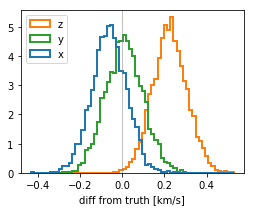

In [27]:
v0_diff = stanfit['v0'] - cl.v0[None,:]

plt.figure(figsize=(4,3))
color = ['tab:blue', 'tab:green', 'tab:orange']
plt.hist(v0_diff, bins=64, histtype='step', density=True, color=color, label=['x','y','z'], lw=2);
plt.xlabel("diff from truth [km/s]");
plt.legend(loc='upper left');
plt.axvline(0, c='gray', lw=.5);

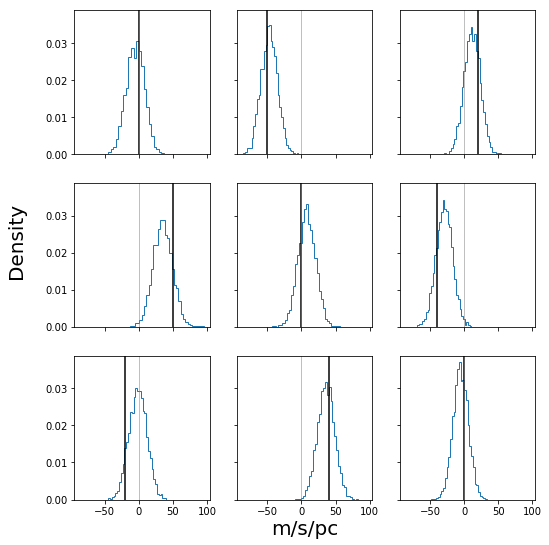

In [28]:
fig, ax = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True)
fig.subplots_adjust(bottom=0.1, top=0.95, right=0.95, left=0.15)
ax = ax.ravel()
for cax, cT, truth in zip(ax, stanfit["T_param"].reshape((-1, 9)).T, cl.T.ravel()):
    cax.hist(cT, bins=32, density=True, histtype="step")
    cax.axvline(truth, c="k")
    cax.axvline(0, c="gray", lw=0.5)
fig.text(0.55, 0.05, "m/s/pc", ha="center", va="center", size=20)
fig.text(0.05, 0.55, "Density", ha="center", va="center", rotation=90, size=20)
fig.savefig("mock_posterior_T.png")

## Cluster with rotation - ideal case

Test the most ideal case when the cluster has small dispersion and all velocities are measured to high preicion.

In [29]:
N = 150
b0 = np.array([17.7, 41.2, 13.3])    # pc
v0 = np.array([-6.32, 45.24, 5.30])
sigv = 0.1 # small dispersion
omegas = [40., 20., 50.]

cl = kn.Cluster(v0, sigv, b0=b0, omegas=omegas)\
       .sample_sphere(N=N, Rmax=15)\
       .observe(cov=np.eye(3)*0.001)
cl0 = kn.Cluster(v0, sigv, b0=b0).sample_at(cl.members.truth.g.icrs)

# Give all stars observed RV with small uncertainty
Nrv = int(N)
rv_error = 0.1
irand = np.random.choice(np.arange(N), size=Nrv, replace=False)

df = cl.members.observed.copy()
df['radial_velocity'] = np.random.normal(cl.members.truth['radial_velocity'].values, rv_error)
df['radial_velocity_error'] = rv_error

In [30]:
m = kn.Fitter(include_T=True)
fit = m.fit(df, sample=False, b0=b0)

INFO:kinesis.models:Reading model from disk


In [31]:
print(f"v0, sigv = {fit['v0']}, {fit['sigv']:.4f}")
print(f"diff from truth: {fit['v0']-v0}, {fit['sigv']-sigv:.4f}")
print(f"{fit['T_param']}")
print(f"{cl.T}")

v0, sigv = [-6.31158325 45.23302118  5.30911615], 0.0974
diff from truth: [ 0.00841675 -0.00697882  0.00911615], -0.0026
[[ -0.53514835 -49.6406874   18.48196561]
 [ 52.87740998   3.07364283 -38.98217046]
 [-19.87667794  42.07821215   2.22755235]]
[[  0. -50.  20.]
 [ 50.   0. -40.]
 [-20.  40.   0.]]


In [32]:
stanfit = m.fit(df, b0=b0)

In [33]:
azfit = az.from_pystan(stanfit, coords={'x':['v1','v2','v3']}, dims={'v0':['x']})
azfit.posterior

<xarray.Dataset>
Dimensions:         (T_param_dim_0: 3, T_param_dim_1: 3, a_model_dim_0: 150, a_model_dim_1: 3, chain: 4, draw: 1000, rv_model_dim_0: 150, x: 3)
Coordinates:
  * chain           (chain) int64 0 1 2 3
  * draw            (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * x               (x) <U2 'v1' 'v2' 'v3'
  * a_model_dim_0   (a_model_dim_0) int64 0 1 2 3 4 5 ... 145 146 147 148 149
  * a_model_dim_1   (a_model_dim_1) int64 0 1 2
  * rv_model_dim_0  (rv_model_dim_0) int64 0 1 2 3 4 5 ... 145 146 147 148 149
  * T_param_dim_0   (T_param_dim_0) int64 0 1 2
  * T_param_dim_1   (T_param_dim_1) int64 0 1 2
Data variables:
    v0              (chain, draw, x) float64 -6.303 45.23 5.299 ... 45.23 5.306
    sigv            (chain, draw) float64 0.1037 0.0987 0.104 ... 0.1028 0.1002
    a_model         (chain, draw, a_model_dim_0, a_model_dim_1) float64 23.24 ... 18.95
    rv_model        (chain, draw, rv_model_dim_0) float64 42.07 41.79 ... 35.94
    T_param    

In [34]:
azfit.sample_stats

<xarray.Dataset>
Dimensions:      (chain: 4, draw: 1000)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    accept_stat  (chain, draw) float64 0.8102 0.9105 0.9356 ... 0.9653 0.813
    stepsize     (chain, draw) float64 0.1635 0.1635 0.1635 ... 0.171 0.171
    treedepth    (chain, draw) int64 5 6 5 5 5 5 5 5 5 5 ... 6 7 6 10 6 5 6 5 6
    n_leapfrog   (chain, draw) int64 31 63 31 63 31 31 ... 1023 127 63 127 31 63
    diverging    (chain, draw) bool False False False ... False False False
    energy       (chain, draw) float64 -1.252e+03 -1.248e+03 ... -1.273e+03
    lp           (chain, draw) float64 1.326e+03 1.335e+03 ... 1.345e+03
Attributes:
    created_at:                 2019-05-22T21:57:36.944296
    inference_library:          pystan
    inference_library_version:  2.18.0.0

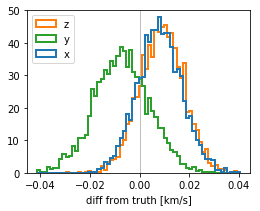

In [35]:
v0_diff = stanfit['v0'] - cl.v0[None,:]

plt.figure(figsize=(4,3))
color = ['tab:blue', 'tab:green', 'tab:orange']
plt.hist(v0_diff, bins=64, histtype='step', density=True, color=color, label=['x','y','z'], lw=2);
plt.xlabel("diff from truth [km/s]");
plt.legend(loc='upper left');
plt.axvline(0, c='gray', lw=.5);

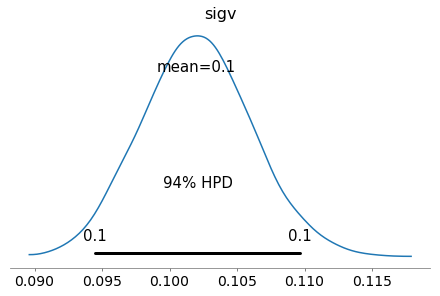

In [36]:
az.plot_posterior(azfit, var_names=['sigv']);

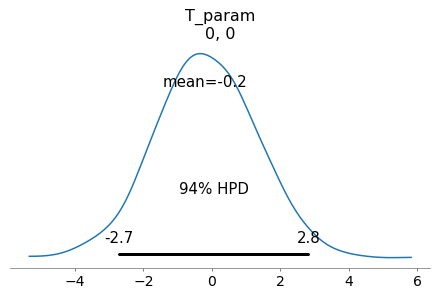

In [37]:
az.plot_posterior(azfit, var_names=['T_param'], coords={'T_param_dim_0':[0], 'T_param_dim_1':[0]});

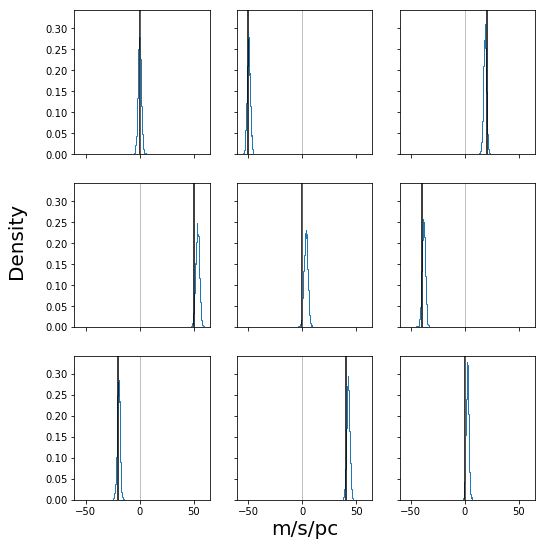

In [38]:
fig, ax = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True)
fig.subplots_adjust(bottom=0.1, top=0.95, right=0.95, left=0.15)
ax = ax.ravel()
for cax, cT, truth in zip(ax, stanfit["T_param"].reshape((-1, 9)).T, cl.T.ravel()):
    cax.hist(cT, bins=32, density=True, histtype="step")
    cax.axvline(truth, c="k")
    cax.axvline(0, c="gray", lw=0.5)
fig.text(0.55, 0.05, "m/s/pc", ha="center", va="center", size=20)
fig.text(0.05, 0.55, "Density", ha="center", va="center", rotation=90, size=20)
fig.savefig("mock_posterior_T.png")

In [40]:
az.summary(azfit, var_names=['v0', 'sigv', 'T_param'])

,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.312,0.009,0.000,0.000,-6.329,-6.295,4194.0,4193.0,4182.0,3104.0,1.0
v0[1],45.233,0.011,0.000,0.000,45.213,45.255,3715.0,3715.0,3726.0,2801.0,1.0
v0[2],5.309,0.009,0.000,0.000,5.292,5.325,3736.0,3736.0,3744.0,2761.0,1.0
sigv,0.102,0.004,0.000,0.000,0.094,0.110,4079.0,4065.0,4091.0,2782.0,1.0
"T_param[0,0]",-0.193,1.470,0.023,0.026,-2.713,2.825,4264.0,1603.0,4248.0,2994.0,1.0
"T_param[0,1]",-49.671,1.497,0.024,0.017,-52.673,-47.076,4041.0,4041.0,4047.0,2859.0,1.0
"T_param[0,2]",18.266,1.330,0.021,0.015,15.793,20.782,4000.0,4000.0,4002.0,2856.0,1.0
"T_param[1,0]",53.288,1.709,0.027,0.019,49.914,56.317,4033.0,4033.0,4037.0,2718.0,1.0
"T_param[1,1]",3.204,1.761,0.028,0.021,0.158,6.763,3929.0,3461.0,3938.0,2981.0,1.0
"T_param[1,2]",-38.332,1.551,0.024,0.017,-41.152,-35.436,4335.0,4335.0,4326.0,3082.0,1.0
